In [1]:
from src.dataset import get_raw_training_data, get_raw_testing_data, get_labels
from src.spacy_helper import format_data_as_spacy, get_spacy_model, train, predict

from src.metrics import score
from src.visualization import plot_confusion_matrix

import numpy as np
import time

In [2]:
raw_training_data = get_raw_training_data('./data/training_set.json')
raw_testing_data = get_raw_testing_data('./data/testing_set.json')

labels = get_labels(raw_training_data)

y_true = [r['intent'] for r in raw_testing_data]
y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)
X_test, y_test = format_data_as_spacy(raw_testing_data)


model = get_spacy_model(labels)

model = train(model, X_train, y_train, 10, test=(X_test, y_test))
model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 16.996481298701838 test score:28.557112666436453%
Iteration 1/10. train_loss: 1.1467092868115287 test score:43.81221059500643%
Iteration 2/10. train_loss: 0.2612756664020708 test score:48.45252925706983%
Iteration 3/10. train_loss: 0.09044494933186797 test score:57.17103483239152%
Iteration 4/10. train_loss: 0.042782374104717746 test score:64.17006466514327%
Iteration 5/10. train_loss: 0.03162787531982758 test score:68.46384090385394%
Iteration 6/10. train_loss: 0.02575508093195822 test score:67.84080286472964%
Iteration 7/10. train_loss: 0.020633657903999847 test score:69.69452640320104%
Iteration 8/10. train_loss: 0.015396986359291986 test score:69.56475442807272%
Iteration 9/10. train_loss: 0.014042770794958415 test score:70.23678481026494%


In [3]:
y_pred = predict(model, X_test)
y_pred_t = predict(model, X_train)

In [4]:
training_results = score(y_true_t, y_pred_t)
testing_results = score(y_true, y_pred)

In [5]:
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.63      0.55      0.59        67
      find-flight       0.60      0.62      0.61        24
       find-hotel       0.75      0.78      0.77        55
  find-restaurant       0.86      0.70      0.77        93
       find-train       0.49      0.81      0.61        21
       irrelevant       0.88      0.93      0.90       677
provide-showtimes       0.73      0.57      0.64        14
         purchase       0.82      0.66      0.73       114

         accuracy                           0.83      1065
        macro avg       0.72      0.70      0.70      1065
     weighted avg       0.83      0.83      0.83      1065



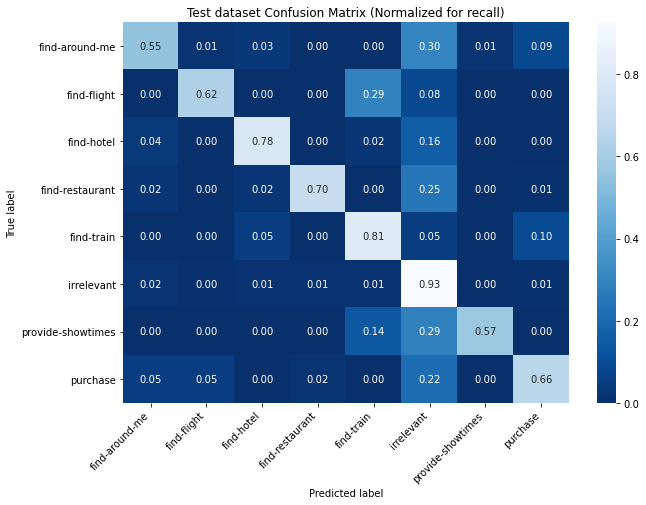

In [6]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

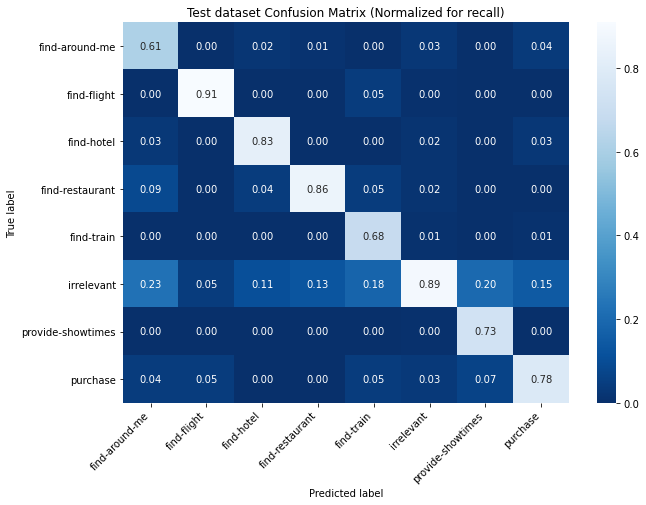

In [16]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

On observe à travers cette matrice de confusion que notre modèle est bien meilleur pour réaliser une classification précise. Cependant, on remarque également qu'il a moins tendance à rediriger vers la classe "irrelevant" lorsqu'il se trompe, ce qui est contraire aux attentes. 

In [7]:
print(training_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.99      0.94      0.97       383
      find-flight       0.96      0.95      0.95       142
       find-hotel       0.98      0.97      0.98       316
  find-restaurant       0.99      0.99      0.99       469
       find-train       0.89      0.99      0.94       143
       irrelevant       0.99      1.00      0.99      3852
provide-showtimes       0.96      0.96      0.96       117
         purchase       0.99      0.98      0.99       613

         accuracy                           0.99      6035
        macro avg       0.97      0.97      0.97      6035
     weighted avg       0.99      0.99      0.99      6035



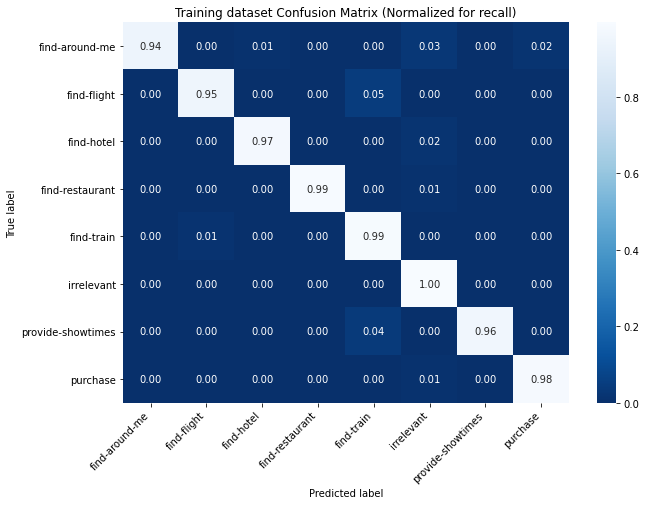

In [8]:
cm_testing_metrics = np.array(training_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Training dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

# With the Augmented Training set

In [9]:
raw_training_data = get_raw_training_data('./data/augmented_training_set.json')

for r in raw_training_data:
    if "message" in r:
        r["sentence"] = r["message"]

y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)

model = get_spacy_model(labels)

model = train(model, X_train, y_train, 18, test=(X_test, y_test))
model.to_disk(f"./model_augmented")

Training the model...
Iteration 0/18. train_loss: 20.217575100134127 test score:50.37041618847681%
Iteration 1/18. train_loss: 0.9145474527758779 test score:64.02844167603652%
Iteration 2/18. train_loss: 0.1753500677186821 test score:69.48637902306152%
Iteration 3/18. train_loss: 0.05542683961903094 test score:71.73699097844853%
Iteration 4/18. train_loss: 0.03178237537485984 test score:71.72758661513274%
Iteration 5/18. train_loss: 0.027235244671146575 test score:72.79258416740291%
Iteration 6/18. train_loss: 0.020111827929667925 test score:74.78171628588444%
Iteration 7/18. train_loss: 0.01475716146219952 test score:75.21058792036999%
Iteration 8/18. train_loss: 0.014396346249611724 test score:72.76084419270455%
Iteration 9/18. train_loss: 0.011502054821619367 test score:73.54993990245586%
Iteration 10/18. train_loss: 0.00940328637326715 test score:76.23399179320283%
Iteration 11/18. train_loss: 0.008406735256777154 test score:74.67769787292498%
Iteration 12/18. train_loss: 0.0070612

In [10]:
y_pred = predict(model, X_test)
y_pred_t = predict(model, X_train)

In [11]:
training_results = score(y_true_t, y_pred_t)
testing_results = score(y_true, y_pred)

In [12]:
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.61      0.64      0.63        67
      find-flight       0.91      0.83      0.87        24
       find-hotel       0.83      0.69      0.75        55
  find-restaurant       0.86      0.77      0.81        93
       find-train       0.68      0.71      0.70        21
       irrelevant       0.89      0.92      0.90       677
provide-showtimes       0.73      0.79      0.76        14
         purchase       0.78      0.75      0.76       114

         accuracy                           0.85      1065
        macro avg       0.79      0.76      0.77      1065
     weighted avg       0.85      0.85      0.85      1065



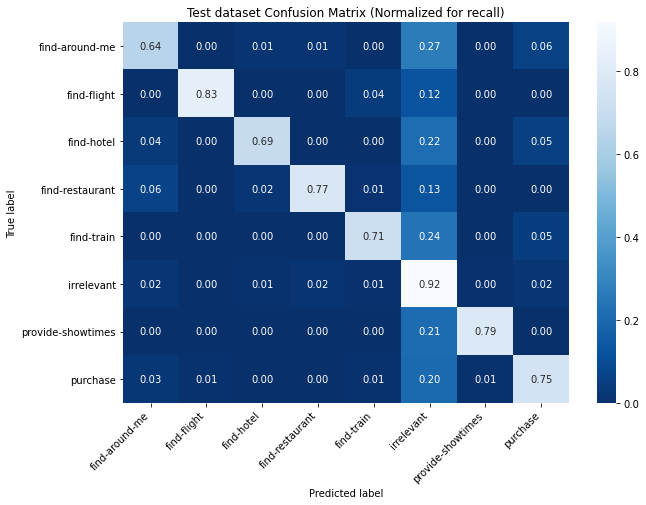

In [13]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

In [14]:
print(training_results['report'])

                   precision    recall  f1-score   support

   find-around-me       1.00      1.00      1.00       600
      find-flight       1.00      1.00      1.00       284
       find-hotel       1.00      1.00      1.00       500
  find-restaurant       1.00      1.00      1.00       700
       find-train       1.00      1.00      1.00       300
       irrelevant       1.00      1.00      1.00      3852
provide-showtimes       1.00      1.00      1.00       300
         purchase       1.00      1.00      1.00       800

         accuracy                           1.00      7336
        macro avg       1.00      1.00      1.00      7336
     weighted avg       1.00      1.00      1.00      7336

